In [1]:
import cpr_gym
import itertools
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from pandarallel import pandarallel
from stable_baselines3 import PPO
from tqdm.notebook import tqdm

tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count(logical=False))
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-49-g7a45c41-dirty (engine: v0.7.0-27-g5283549-dirty)
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: v0.7.0-27-g5283549-dirty


In [2]:
# Fix model import
import sys
import experiments.train.cfg_model as cfg_model

sys.modules[
    "cfg_model"
] = cfg_model  # cfg_model should be moved somewhere else, I guess

In [3]:
protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)
episode_len = 2048
n_episodes = 25
batches = [
    # "2023-01-10_tailstorm-8-constant",
    # "2023-01-11_nakamoto", # broken, is it because is was trained on python3.11?
    # "2023-01-11_bk-8",
    # "2023-01-12_nakamoto",
    "2023-01-13_full",
]


def env_fn(x, episode_len=episode_len):
    env = gym.make(
        "cpr_gym:cpr-v0",
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
        episode_len=episode_len,
    )
    return env

# Data generation

## Find trained models

In [4]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)
            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reused=False)
models

protocol  k    reward subblock_selection  alpha  gamma  \
0     nakamoto  1  constant                n/a   0.40   0.50   
1           bk  8  constant                n/a   0.30   0.50   
2           bk  8  constant                n/a   0.35   0.95   
3    tailstorm  8  constant          heuristic   0.45   0.95   
4           bk  8  constant                n/a   0.20   0.05   
..         ... ..       ...                ...    ...    ...   
253  tailstorm  8  constant          heuristic   0.20   0.50   
254  tailstorm  8  constant          heuristic   0.30   0.95   
255  tailstorm  8  constant          heuristic   0.30   0.05   
256  tailstorm  8  constant          heuristic   0.35   0.95   
257   nakamoto  1  constant                n/a   0.25   0.50   

                policy                                               path  \
0    ppo-3v2m5ocu-best  data/models/2023-01-13_full/ppo-nakamoto-alpha...   
1    ppo-1e9o7366-last  data/models/2023-01-13_full/ppo-bk-8-alpha30-g...   
2    ppo-g83r0rsn-last  data/models/2023-01-13_full/ppo-bk-8-alpha35-g...   
3    ppo-39q2qnww-last  data/models/2023-01-13_full/ppo-tailstorm-8-co...   
4    ppo-18y7ade5-best  data/models/2023-01-13_full/ppo-bk-8-alpha20-g...   
..                 ...                                                ...   
253  ppo-jheysu0r-best  data/models/2023-01-13_full/ppo-tailstorm-8-co...   
254  ppo-27acvjcj-last  data/models/2023-01-13_full/ppo-tailstorm-8-co...   
255  ppo-7sajycuv-last  data/models/2023-01-13_full/ppo-tailstorm-8-co...   
256  ppo-1z09su84-best  data/models/2023-01-13_full/ppo-tailstorm-8-co...   
257  ppo-17kygahr-last  data/models/2023-01-13_full/ppo-nakamoto-alpha...   

        kind  reused  
0    trained   False  
1    trained   False  
2    trained   False  
3    trained   False  
4    trained   False  
..       ...     ...  
253  trained   False  
254  trained   False  
255  trained   False  
256  trained   False  
257  trained   False  

[258 rows x 10 columns]

In [5]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reused=True, reward="discount"
        ),
    ]
)
# models

## Find hard-coded policies

In [6]:
def hard_coded_policies(models):
    for _idx, x in models[
        ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
    ].iterrows():
        env = env_fn(x)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reused=False)
)
hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

protocol  k    reward subblock_selection                policy  \
0     nakamoto  1  constant                n/a  sapirshtein-2016-sm1   
1     nakamoto  1  constant                n/a       eyal-sirer-2014   
2     nakamoto  1  constant                n/a                simple   
3     nakamoto  1  constant                n/a                honest   
4           bk  8  constant                n/a               selfish   
5           bk  8  constant                n/a                honest   
8    tailstorm  8  constant          heuristic      override-catchup   
9    tailstorm  8  constant          heuristic        override-block   
10   tailstorm  8  constant          heuristic         release-block   
11   tailstorm  8  constant          heuristic                honest   
896  tailstorm  8  discount          heuristic      override-catchup   
897  tailstorm  8  discount          heuristic        override-block   
898  tailstorm  8  discount          heuristic         release-block   
899  tailstorm  8  discount          heuristic                honest   

           kind path  reused  
0    hard-coded  n/a   False  
1    hard-coded  n/a   False  
2    hard-coded  n/a   False  
3    hard-coded  n/a   False  
4    hard-coded  n/a   False  
5    hard-coded  n/a   False  
8    hard-coded  n/a   False  
9    hard-coded  n/a   False  
10   hard-coded  n/a   False  
11   hard-coded  n/a   False  
896  hard-coded  n/a   False  
897  hard-coded  n/a   False  
898  hard-coded  n/a   False  
899  hard-coded  n/a   False

## Run simulations

In [7]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)

loaded = {}


def load(path):
    if path in loaded.keys():
        return loaded[path]
    else:
        m = PPO.load(path)
        loaded[path] = m
        return m


def observe_episode(info):
    r = dict()
    for k, v in info.items():
        if k.startswith("episode_"):
            r[k] = v
    return pd.Series(r)


def measure_trained(x, env_fn=env_fn, **kwargs):
    env = env_fn(x)
    model = load(x.path)
    obs = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _reward, done, info = env.step(action)
    return observe_episode(info)


def measure_hardcoded(x, env_fn=env_fn, **kwargs):
    env = env_fn(x)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, x.policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


def measure(x, **kwargs):
    if x.kind == "trained":
        return measure_trained(x, **kwargs)
    if x.kind == "hard-coded":
        return measure_hardcoded(x, **kwargs)
    assert False


# run simulations or restore from cached file

digest = hex(abs(hash(tuple([episode_len] + pd.util.hash_pandas_object(episodes)))))
fname = f"data/rl-eval-episodes-{digest}.pkl"
try:
    # raise FileNotFoundError # force re-compute
    episodes = pd.read_pickle(fname)
    print(f"restore from {fname}")
except FileNotFoundError:
    # results = episodes.progress_apply(measure, axis=1)
    with threadpoolctl.threadpool_limits(limits=1):
        results = episodes.parallel_apply(measure, axis=1)
    episodes = pd.concat([episodes, results], axis=1)
    episodes.to_pickle(fname)
    episodes.columns

In [8]:
list(episodes.columns)

['protocol',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'policy',
 'path',
 'kind',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations']

# Find optimal policies

In [9]:
scenario = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "kind"]
policy = ["policy", "reused", "path"]
d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

protocol  k    reward subblock_selection  alpha  gamma        kind  \
0           bk  8  constant                n/a   0.20   0.05  hard-coded   
1           bk  8  constant                n/a   0.20   0.05     trained   
2           bk  8  constant                n/a   0.20   0.50  hard-coded   
3           bk  8  constant                n/a   0.20   0.50     trained   
4           bk  8  constant                n/a   0.20   0.95  hard-coded   
..         ... ..       ...                ...    ...    ...         ...   
139  tailstorm  8  discount          heuristic   0.45   0.05     trained   
140  tailstorm  8  discount          heuristic   0.45   0.50  hard-coded   
141  tailstorm  8  discount          heuristic   0.45   0.50     trained   
142  tailstorm  8  discount          heuristic   0.45   0.95  hard-coded   
143  tailstorm  8  discount          heuristic   0.45   0.95     trained   

                policy  reused  
0               honest   False  
1    ppo-16f6jy7g-best   False  
2               honest   False  
3    ppo-2vco0po3-best   False  
4               honest   False  
..                 ...     ...  
139  ppo-2roy8y21-best    True  
140     override-block   False  
141  ppo-1sbwru39-best    True  
142     override-block   False  
143  ppo-39q2qnww-best    True  

[144 rows x 9 columns]

# Compare RL against best hard-coded

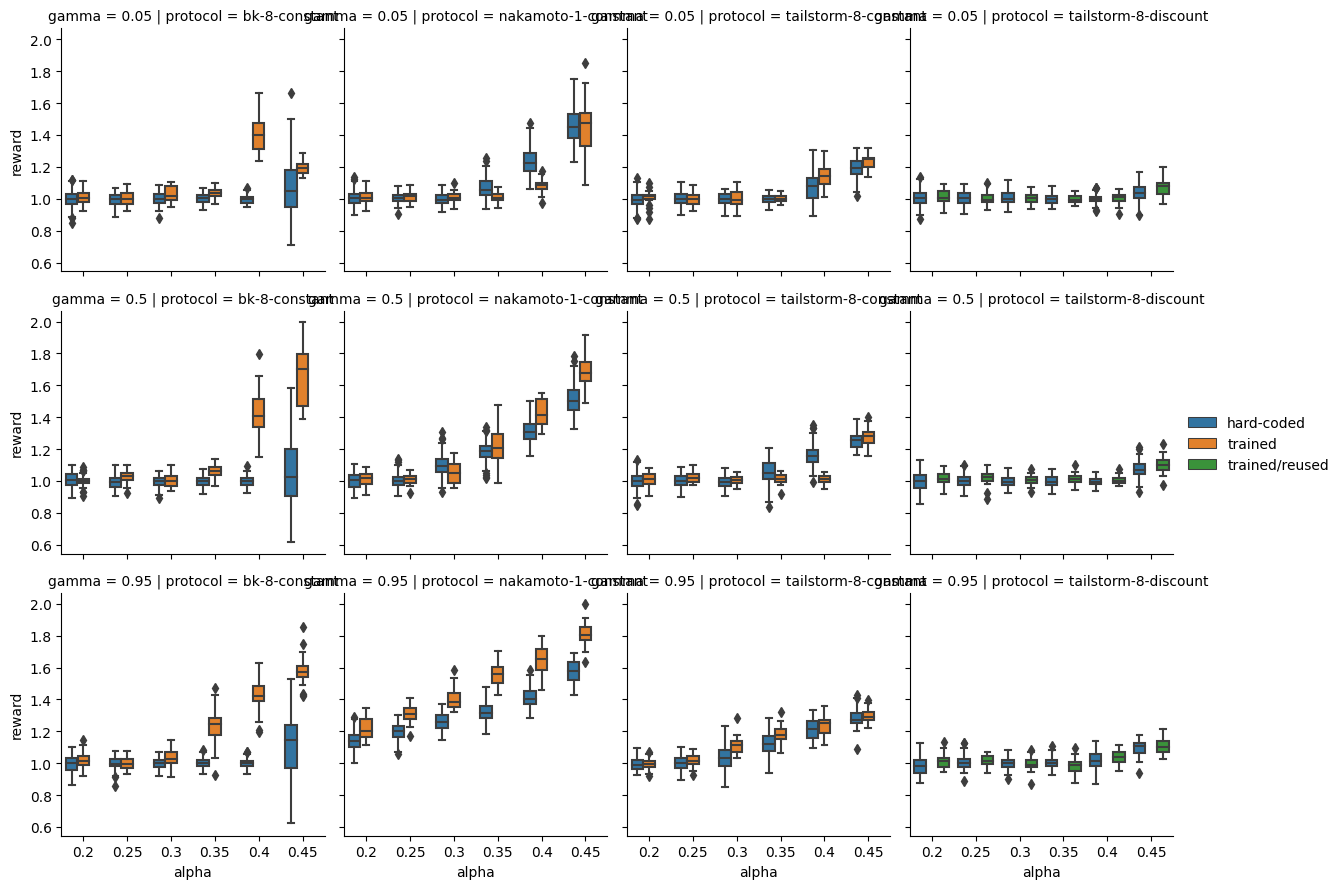

In [10]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(data=d, col="protocol", row="gamma")
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

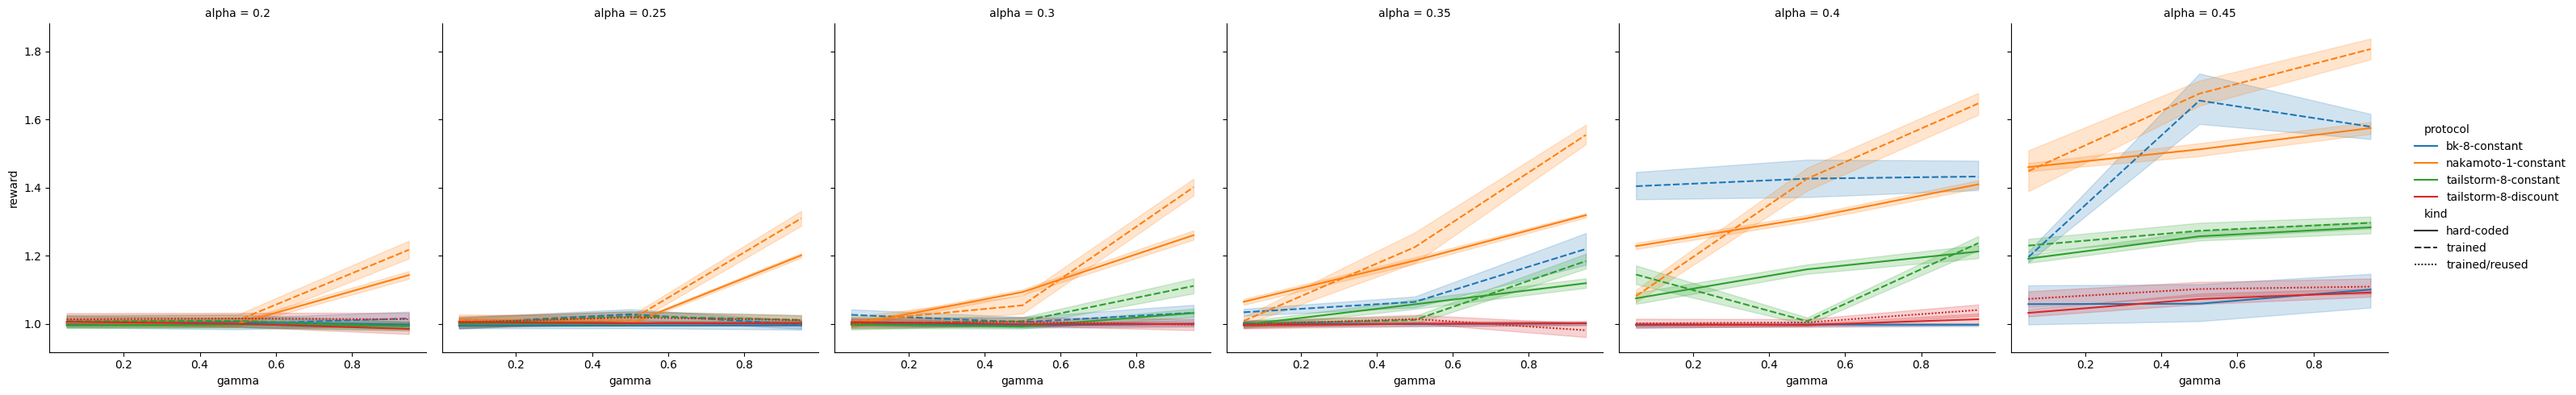

In [11]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

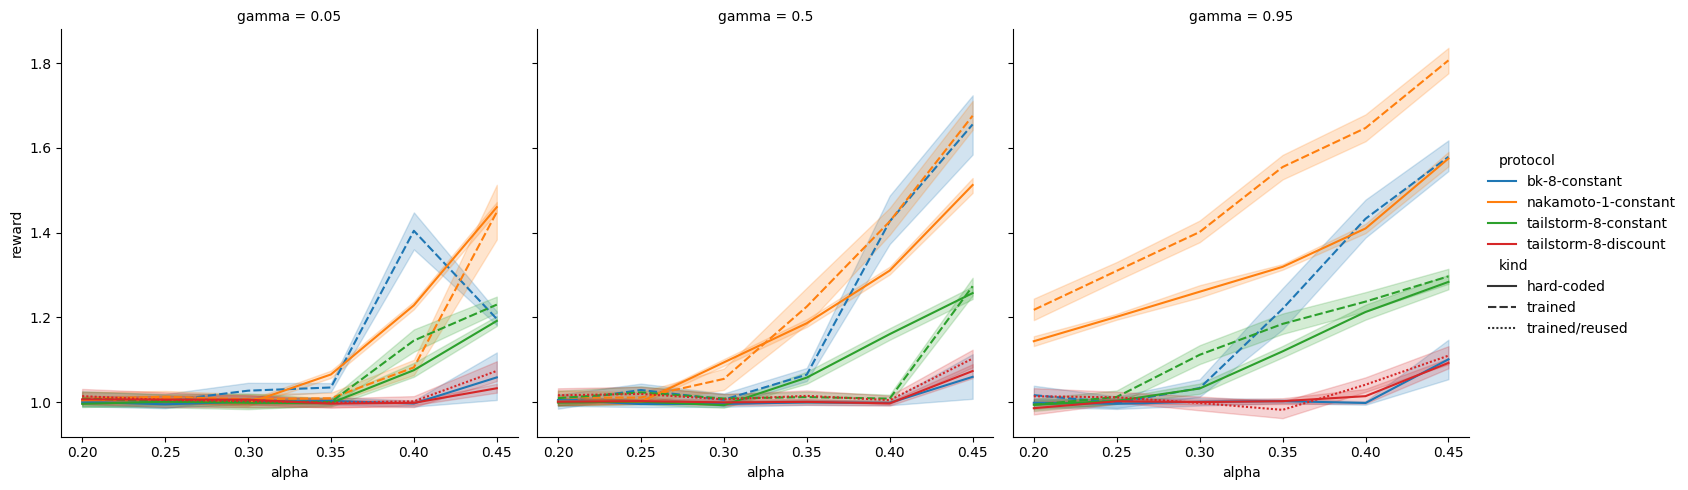

In [12]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

# Honest or Attack?

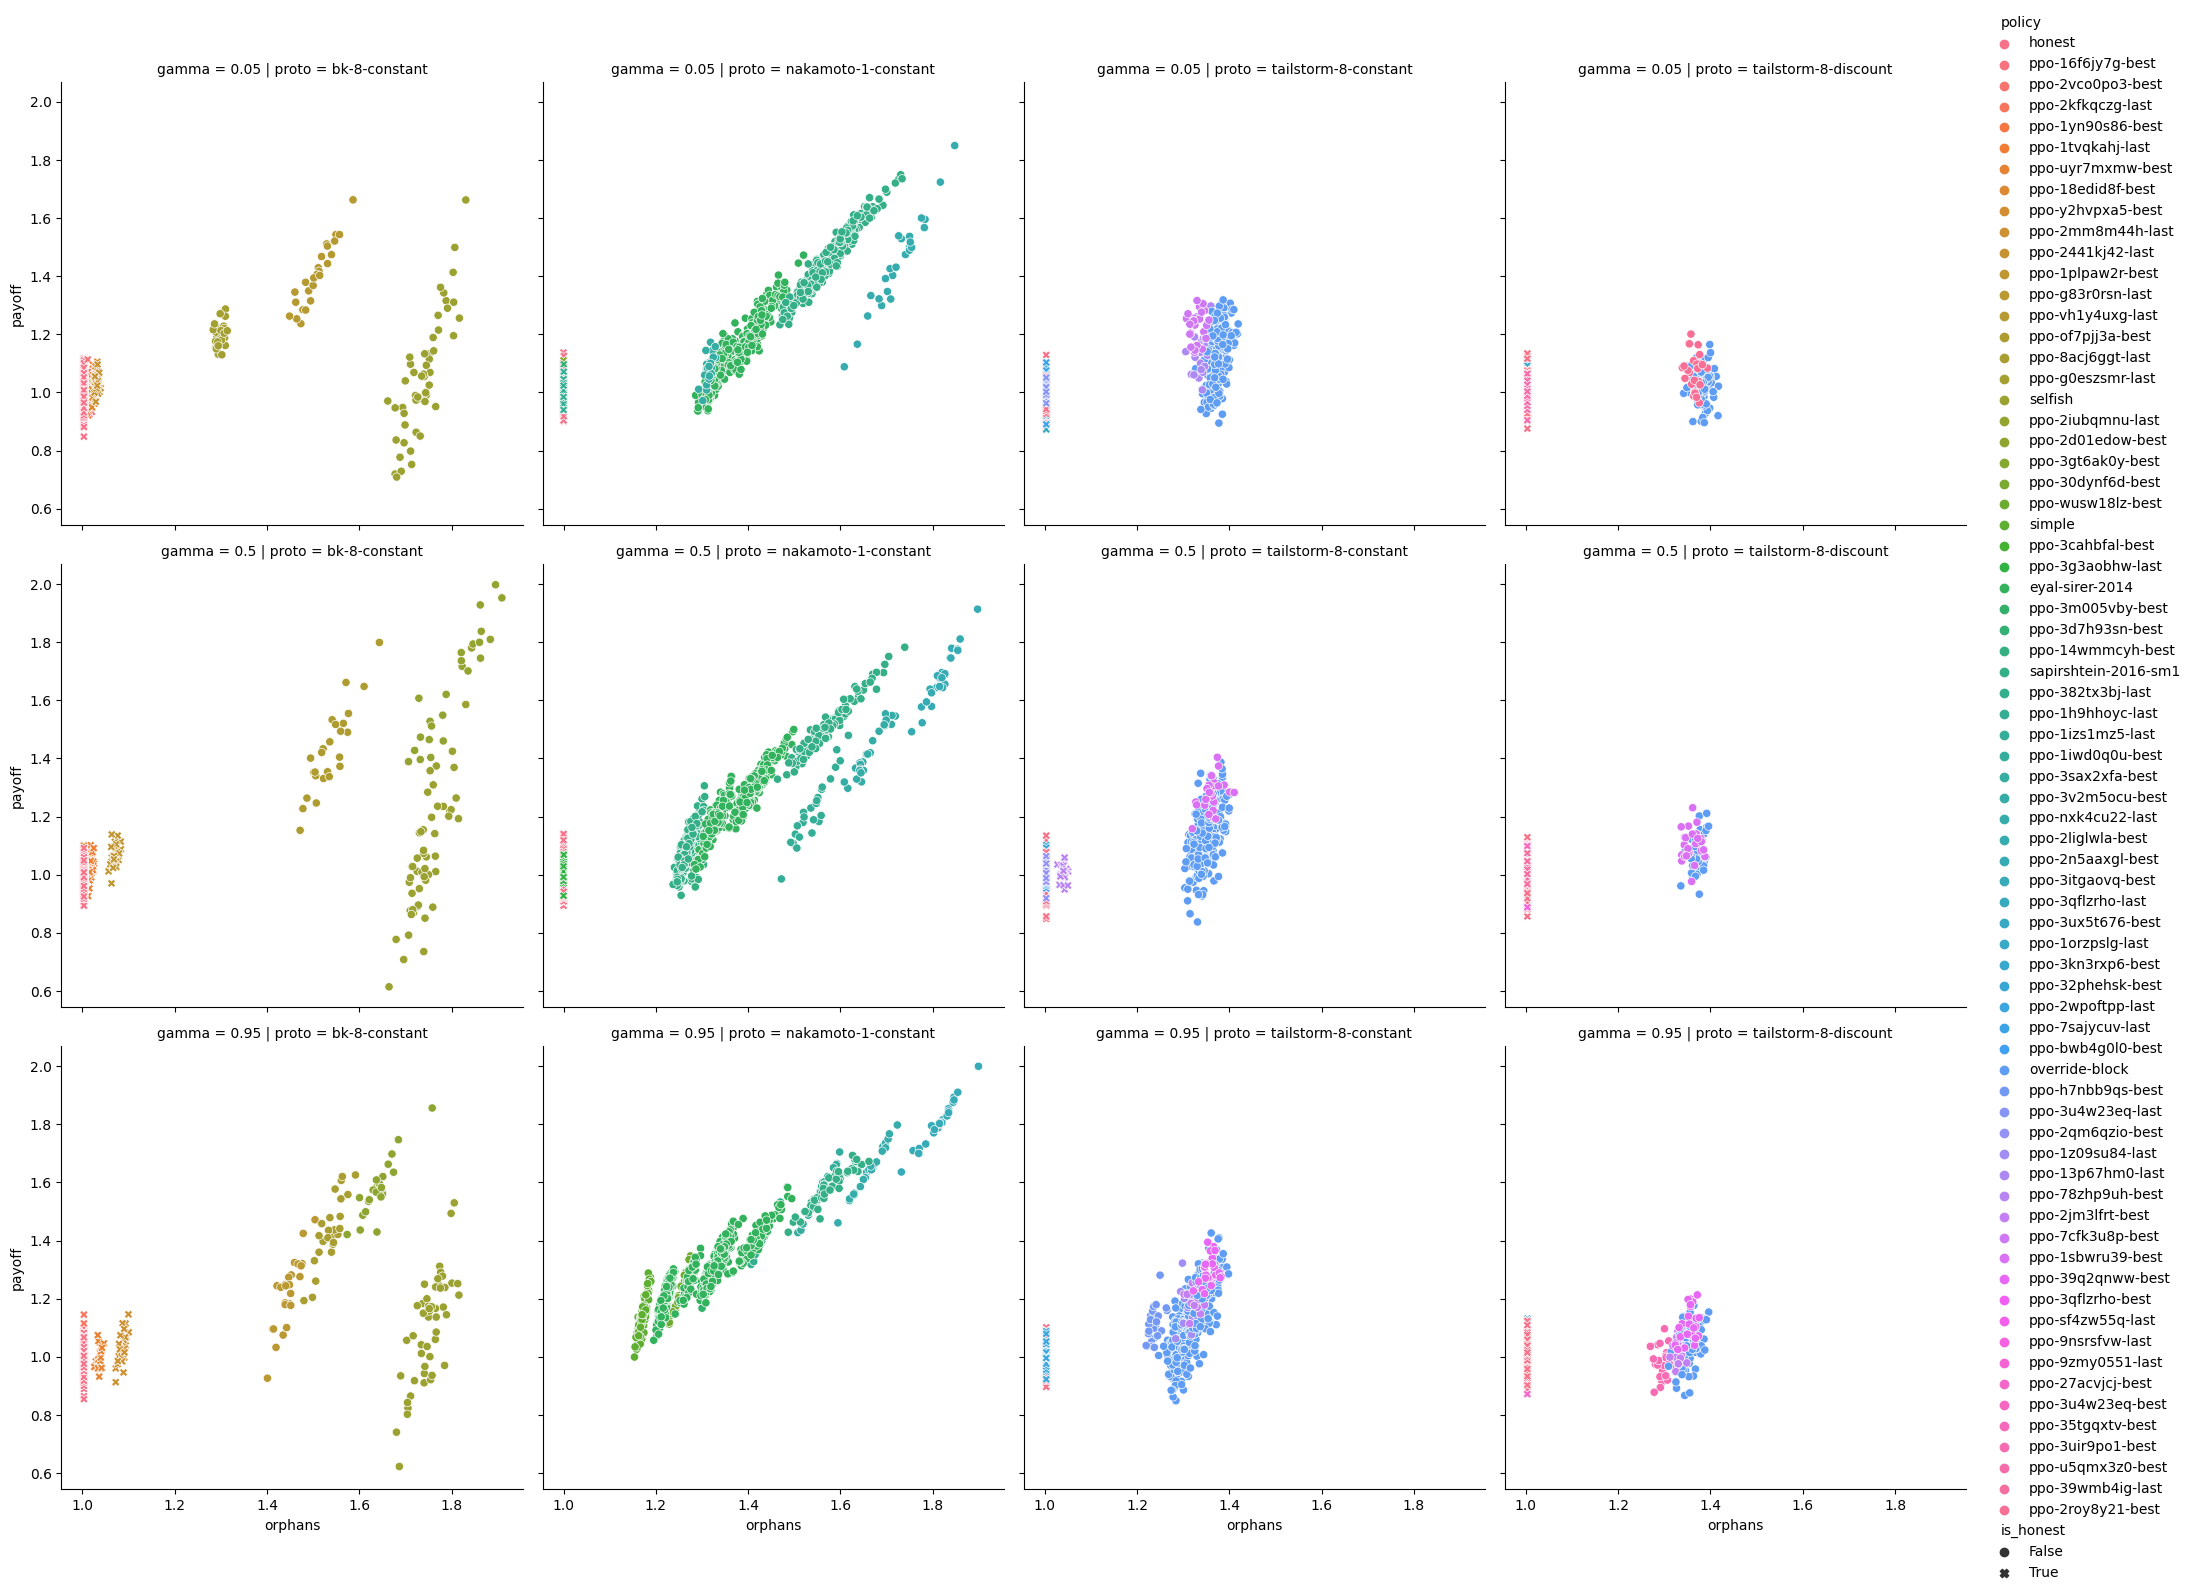

In [13]:
grouping = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "policy"]
d = opt_episodes.copy()
d["orphans"] = d.episode_n_activations / d.episode_progress
d["proto"] = d.protocol + "-" + d.k.map(str) + "-" + d.reward
d["payoff"] = d.episode_reward_attacker / d.episode_progress / d.alpha
dd = d.groupby(grouping).agg(
    mean_orphans=("orphans", "mean"),
    mean_payoff=("payoff", "mean"),
    std_payoff=("payoff", "std"),
)
d = d.set_index(grouping + ["episode"]).join(dd).reset_index()
d["is_honest"] = d.mean_orphans <= 1.15
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="policy",
    style="is_honest",
    row="gamma",
    col="proto",
)
honest_or_attack_episodes = d  # for later use
# list(d.columns)

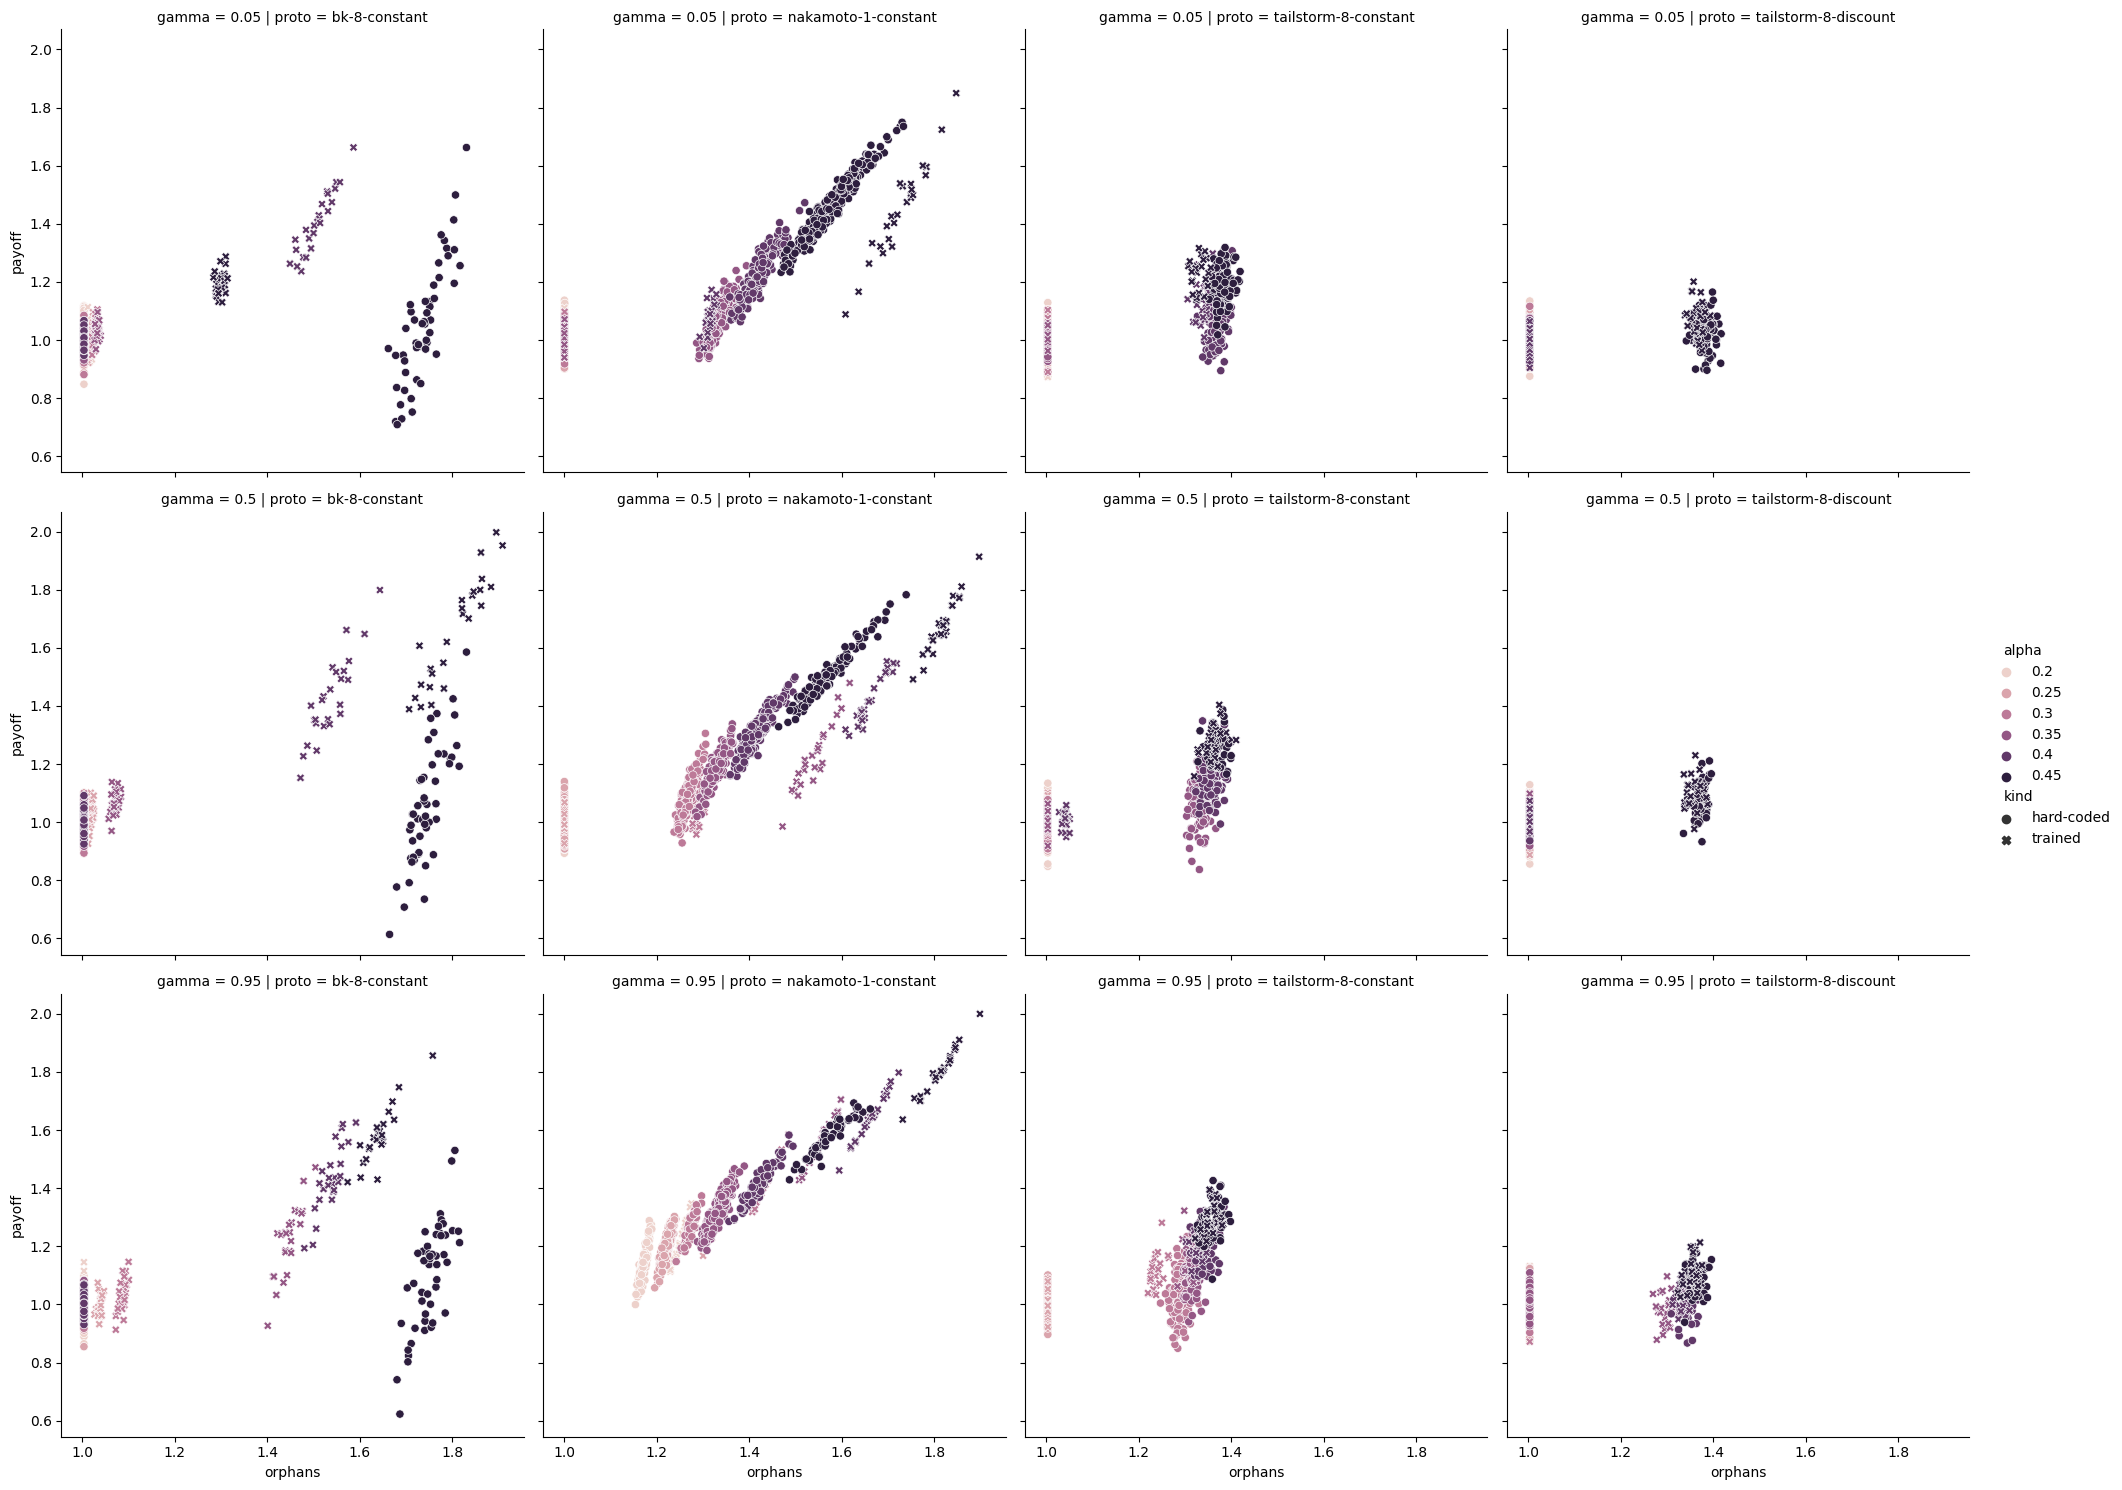

In [14]:
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

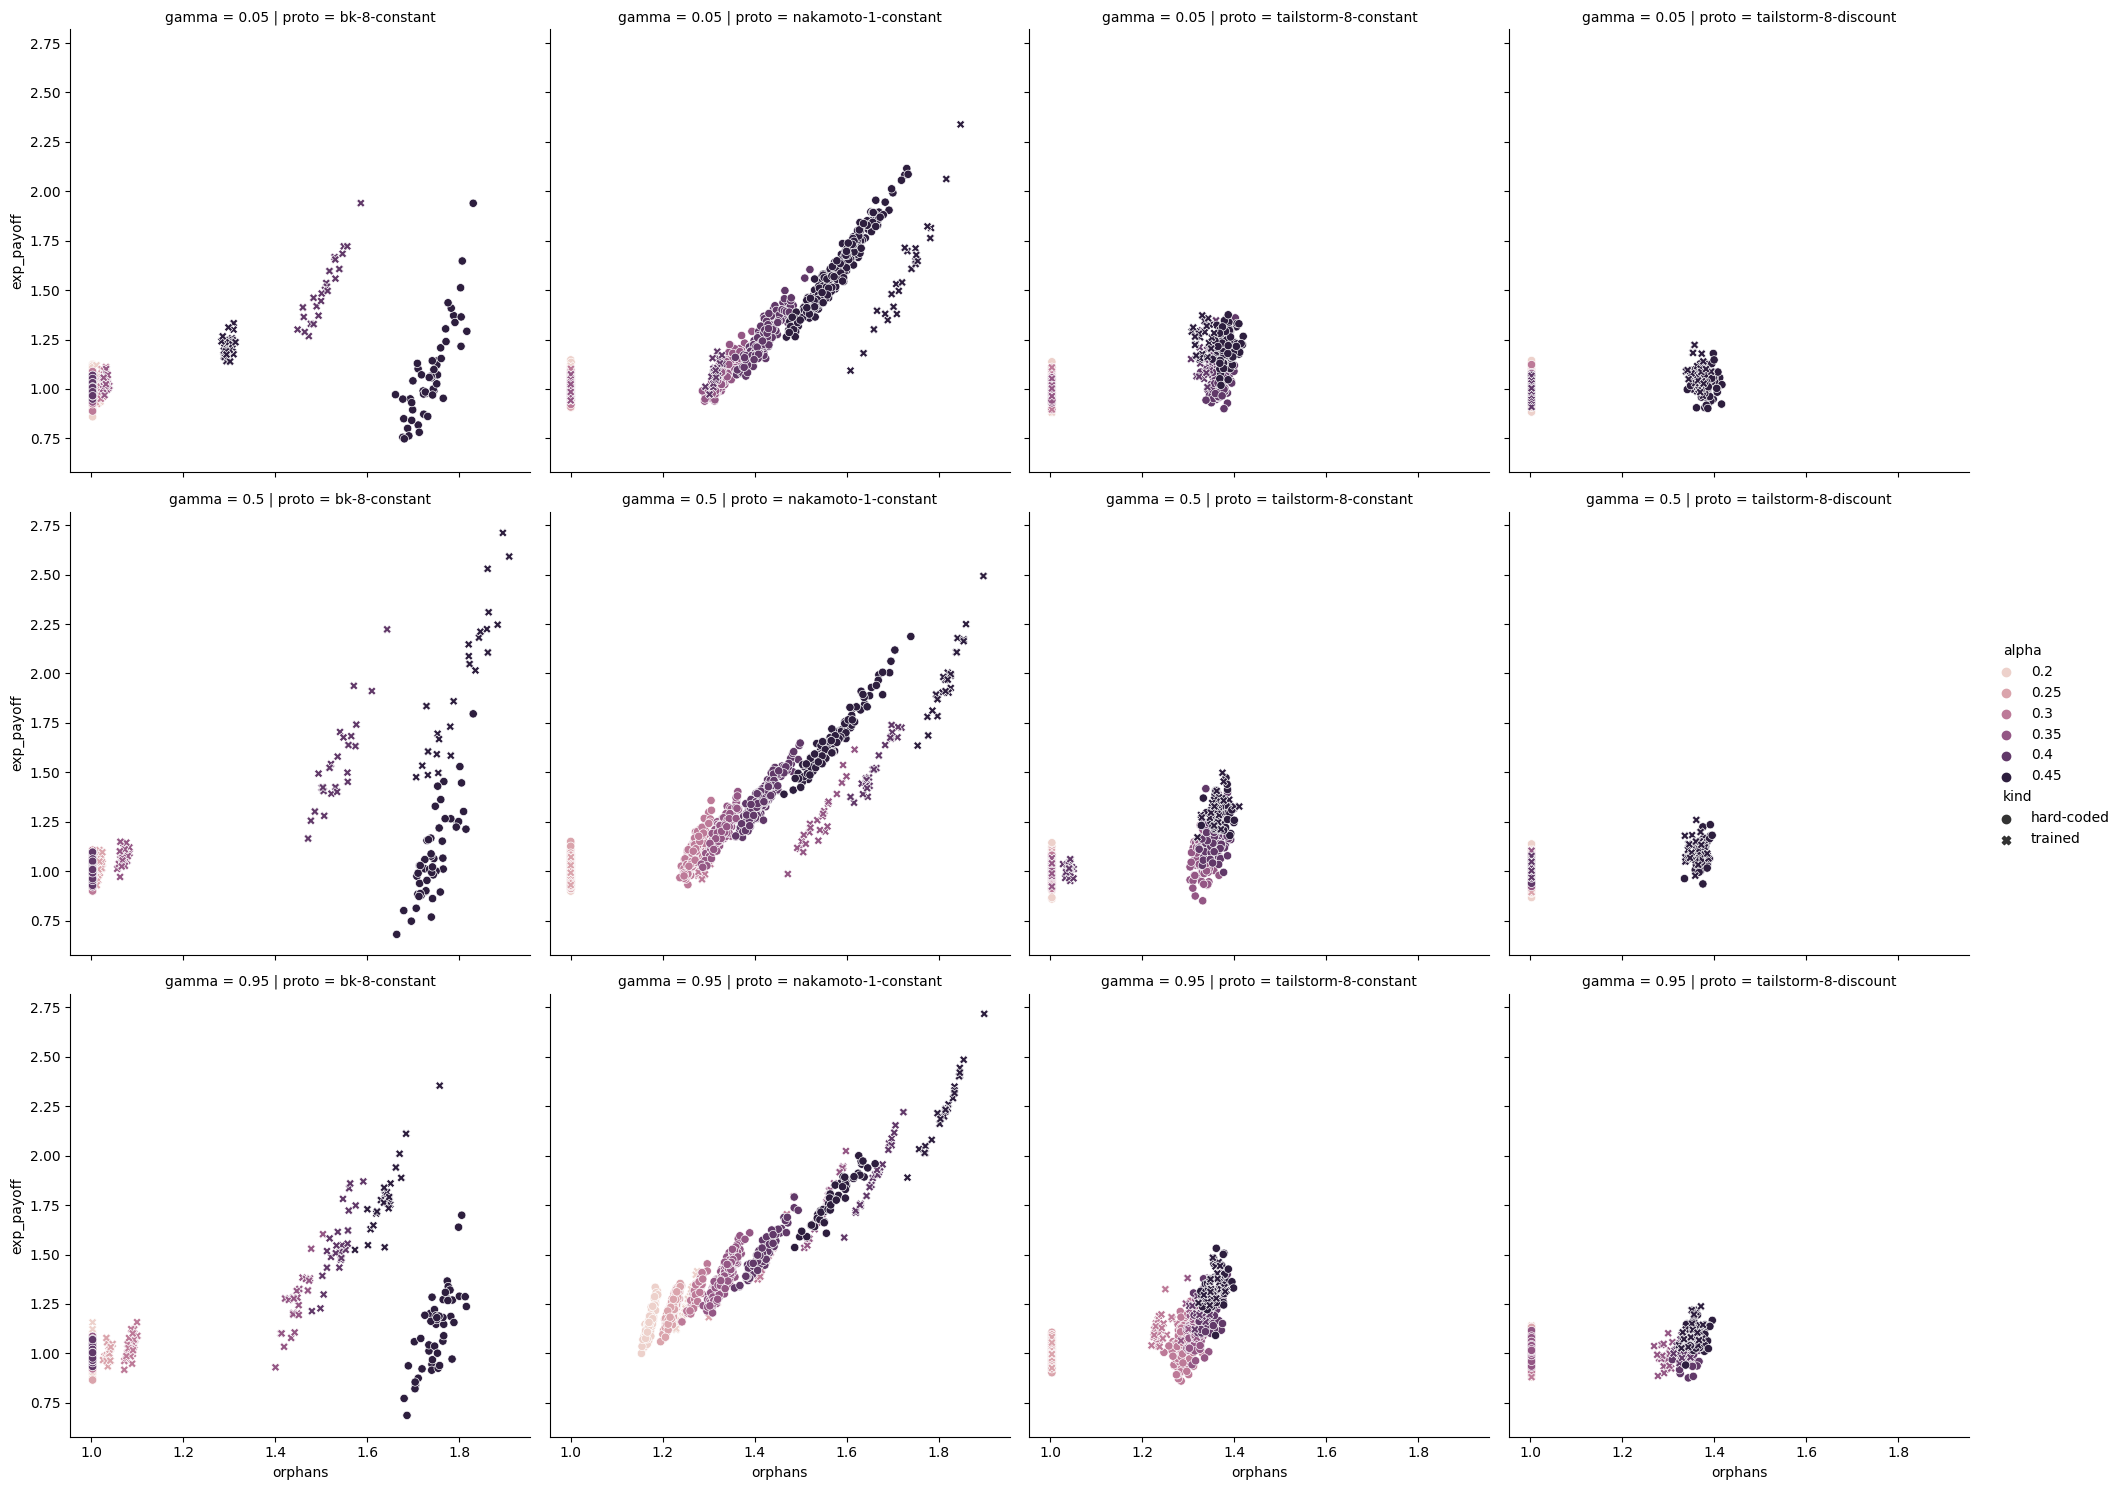

In [15]:
sns.relplot(
    data=d.assign(exp_payoff=np.exp(d.payoff - 1)),
    x="orphans",
    y="exp_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

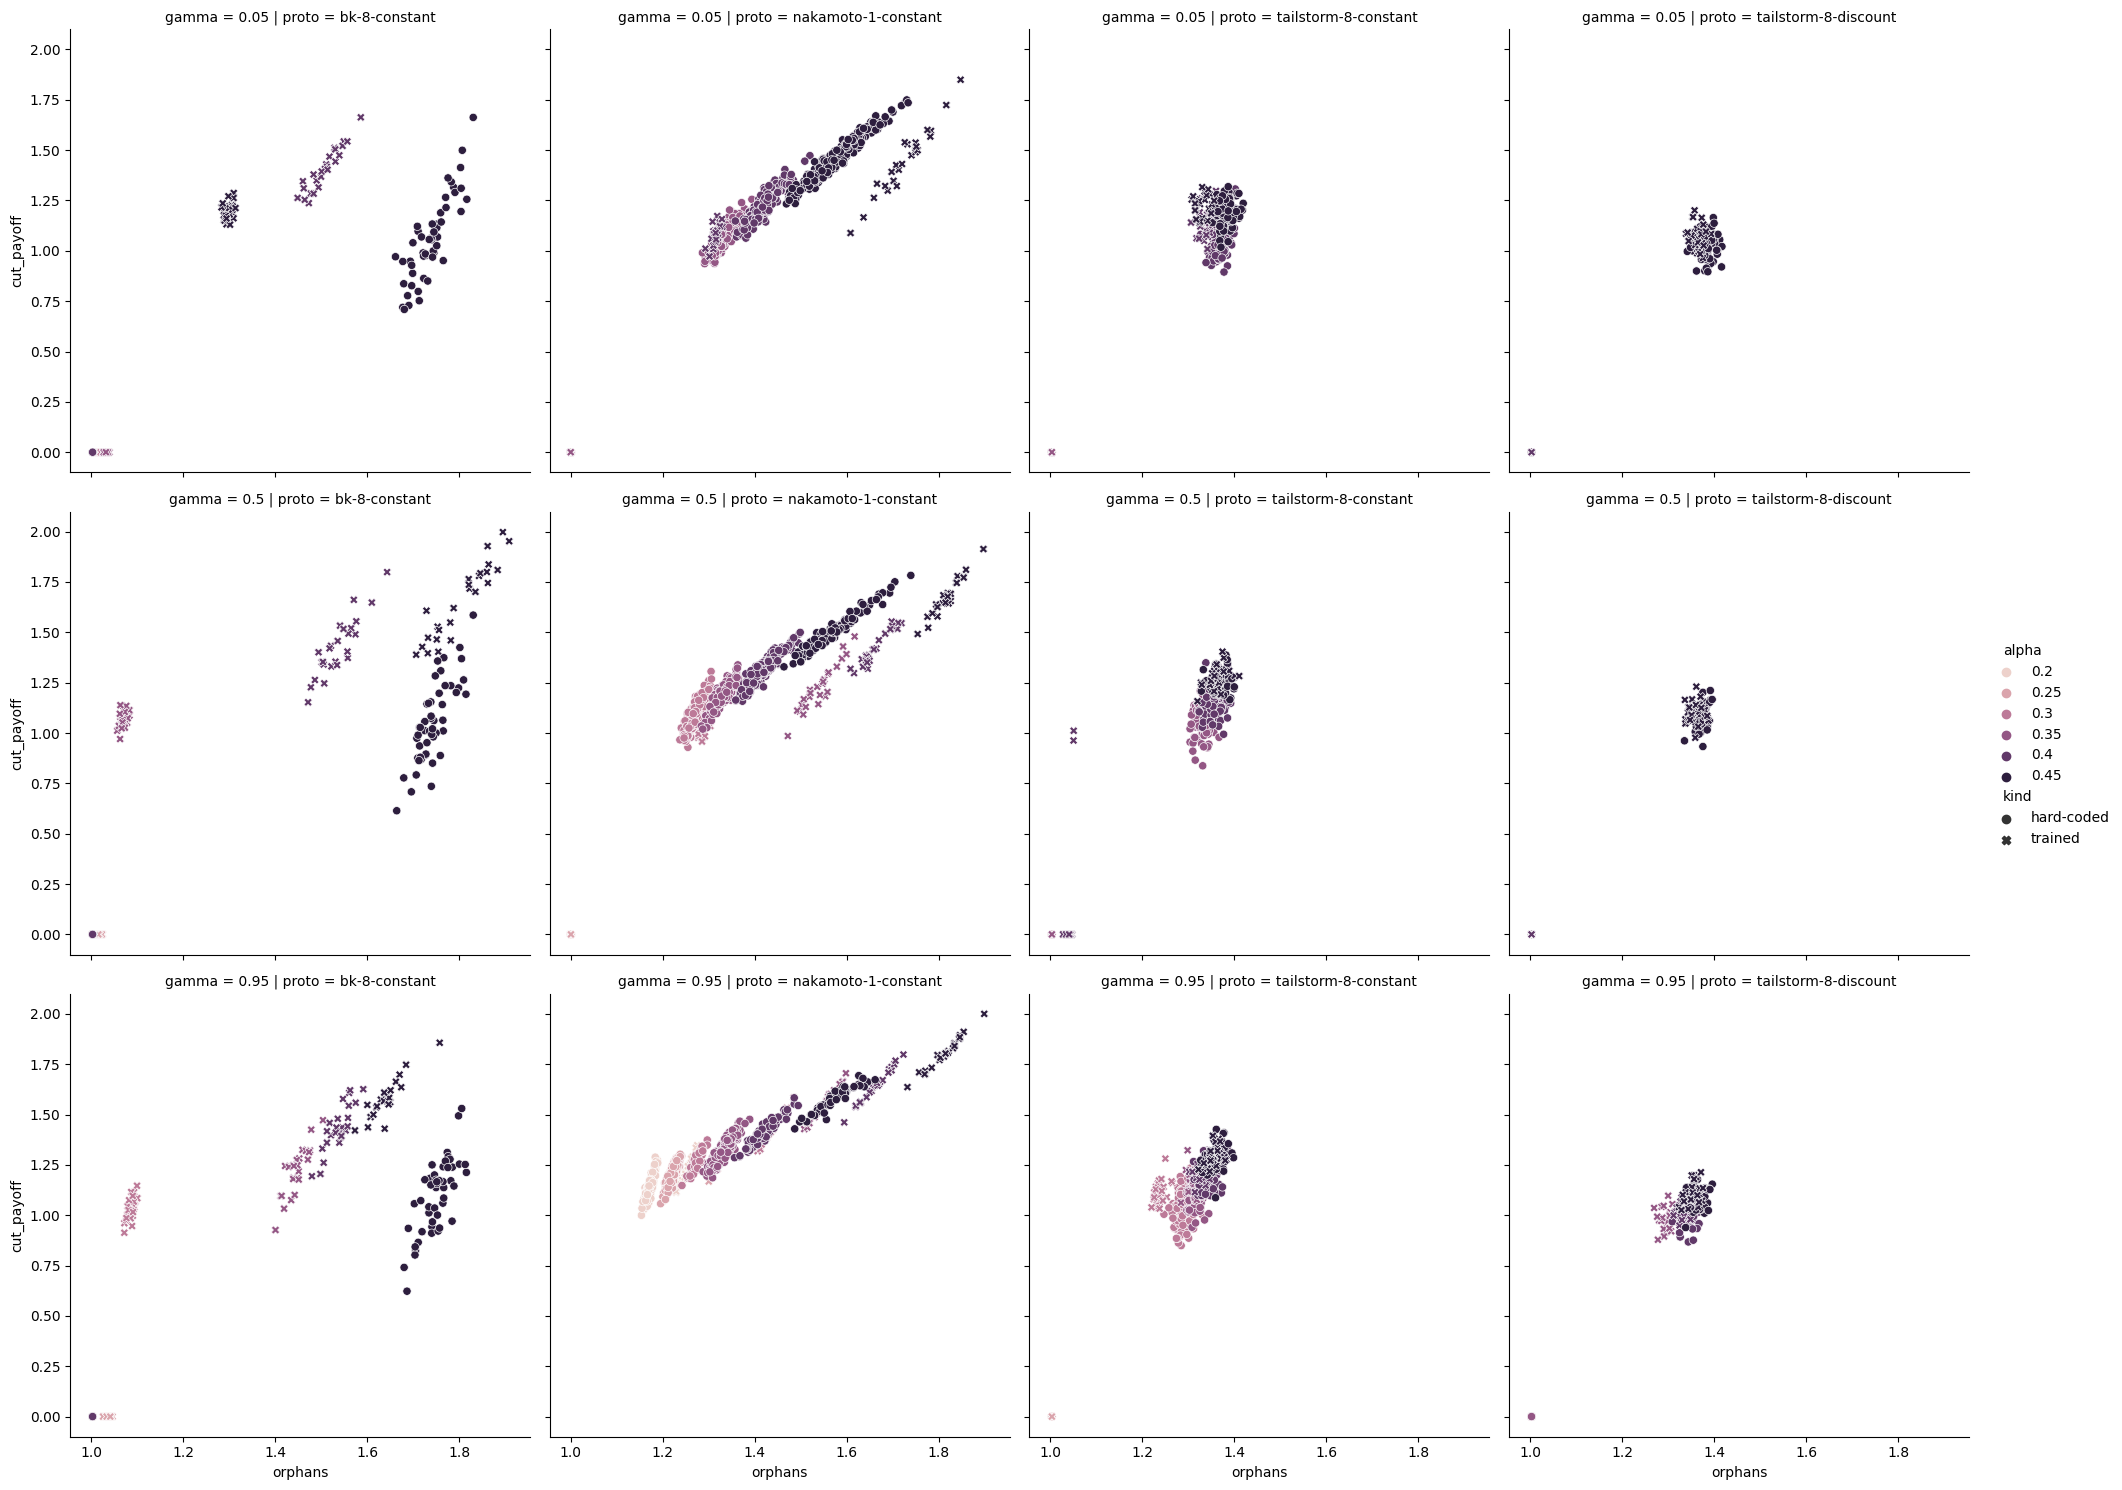

In [16]:
sns.relplot(
    data=d.assign(
        cut_payoff=[x.payoff if x.orphans > 1.05 else 0 for _, x in d.iterrows()]
    ),
    x="orphans",
    y="cut_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [17]:
grouping = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
select = ["policy", "reused", "path"]
d = honest_or_attack_episodes.query("is_honest == False")
d = d[grouping + ["alpha"] + select].drop_duplicates().reset_index(drop=True)
d = d.loc[d.groupby(grouping).alpha.idxmin()].reset_index(drop=True)
be_policies = d
display(be_policies.drop(columns="path"))

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.45   
1          bk  8  constant                n/a   0.05     trained   0.40   
2          bk  8  constant                n/a   0.50  hard-coded   0.45   
3          bk  8  constant                n/a   0.50     trained   0.40   
4          bk  8  constant                n/a   0.95  hard-coded   0.45   
5          bk  8  constant                n/a   0.95     trained   0.35   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.40   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.30   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.40   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.45   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.35   

                  policy  reused  
0                selfish   False  
1      ppo-vh1y4uxg-last   False  
2                selfish   False  
3      ppo-of7pjj3a-best   False  
4                selfish   False  
5      ppo-g83r0rsn-last   False  
6        eyal-sirer-2014   False  
7      ppo-3sax2xfa-best   False  
8   sapirshtein-2016-sm1   False  
9      ppo-14wmmcyh-best   False  
10                simple   False  
11     ppo-wusw18lz-best   False  
12        override-block   False  
13     ppo-13p67hm0-last   False  
14        override-block   False  
15     ppo-1sbwru39-best   False  
16        override-block   False  
17     ppo-h7nbb9qs-best   False  
18        override-block   False  
19     ppo-2roy8y21-best    True  
20        override-block   False  
21     ppo-1sbwru39-best    True  
22        override-block   False  
23     ppo-3uir9po1-best    True

In [18]:
import io
import joblib
import skopt
import skopt.plots
from skopt.space import Real
from skopt.utils import use_named_args

support = [0.1, 0.5]
dimensions = [Real(name="alpha", low=min(support), high=max(support))]
n_calls = 42
be_episode_len = 8192


def objective_fn(policy):
    @use_named_args(dimensions=dimensions)
    def fn(alpha):
        x = policy.copy()
        x["alpha"] = alpha
        r = measure(
            x,
            env_fn=lambda x: env_fn(x, episode_len=be_episode_len),
            pretend_alpha=policy.alpha,
        )
        return np.abs(
            (r["episode_reward_attacker"] / r["episode_progress"] / alpha) - 1
        )

    return fn


def png_of_optimization(x, res, break_even):
    fig = plt.figure()
    ax = skopt.plots.plot_gaussian_process(res)
    ax.axvline(break_even, linestyle="solid", label="minimum/break-even")
    ax.axvline(res.x[0], linestyle="dashed", label="minimal observation")
    ax.legend(loc="best", numpoints=1)
    ax.set_xlabel("α")
    ax.set_ylabel("f(α)")
    ax.set_title(
        f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    )
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    plt.close()
    buf.seek(0)
    return buf.getvalue()


def break_even_of_res(res):
    # res.x gives argmin of observation
    # the observations are stochastic, hence we cannot use res.x
    # revert last surrogate function instead
    # surrogate has support 0..1, thus transform alphas
    return res.x_iters[
        np.argmin(
            res.models[-1].predict(
                (np.array(res.x_iters) - min(support)) / (max(support) - min(support))
            )
        )
    ][0]


def find_break_even(x):
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", "The objective has been evaluated at this point before"
        )
        res = skopt.gp_minimize(objective_fn(x), dimensions, n_calls=n_calls, n_jobs=1)
        break_even = break_even_of_res(res)
        # optimizer result cannot be pickled
        # thus create plot here and save in dataframe
        png = png_of_optimization(x, res, break_even)
    return pd.Series(dict(break_even=break_even, break_even_png=png))


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[7]]
d = be_policies

digest = hex(
    abs(hash(tuple([be_episode_len, n_calls] + list(pd.util.hash_pandas_object(d)))))
)
fname = f"data/rl-eval-break-even-points-{digest}.pkl"
try:
    be_points = pd.read_pickle(fname)
    print(f"restore from {fname}")
except FileNotFoundError:
    # results = d.progress_apply(find_break_even, axis = 1)
    with threadpoolctl.threadpool_limits(limits=1):
        results = d.parallel_apply(find_break_even, axis=1)
    be_points = pd.concat([d, results], axis=1)
    be_points.to_pickle(fname)

In [19]:
be_points.drop(columns=["path", "break_even_png"])

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.45   
1          bk  8  constant                n/a   0.05     trained   0.40   
2          bk  8  constant                n/a   0.50  hard-coded   0.45   
3          bk  8  constant                n/a   0.50     trained   0.40   
4          bk  8  constant                n/a   0.95  hard-coded   0.45   
5          bk  8  constant                n/a   0.95     trained   0.35   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.40   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.30   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.40   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.45   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.35   

                  policy  reused  break_even  
0                selfish   False    0.446847  
1      ppo-vh1y4uxg-last   False    0.294100  
2                selfish   False    0.447827  
3      ppo-of7pjj3a-best   False    0.304721  
4                selfish   False    0.446583  
5      ppo-g83r0rsn-last   False    0.300750  
6        eyal-sirer-2014   False    0.324407  
7      ppo-3sax2xfa-best   False    0.367538  
8   sapirshtein-2016-sm1   False    0.249436  
9      ppo-14wmmcyh-best   False    0.279080  
10                simple   False    0.100000  
11     ppo-wusw18lz-best   False    0.100000  
12        override-block   False    0.373947  
13     ppo-13p67hm0-last   False    0.326522  
14        override-block   False    0.328437  
15     ppo-1sbwru39-best   False    0.303236  
16        override-block   False    0.283577  
17     ppo-h7nbb9qs-best   False    0.226233  
18        override-block   False    0.443650  
19     ppo-2roy8y21-best    True    0.428790  
20        override-block   False    0.413898  
21     ppo-1sbwru39-best    True    0.394940  
22        override-block   False    0.397963  
23     ppo-3uir9po1-best    True    0.386329

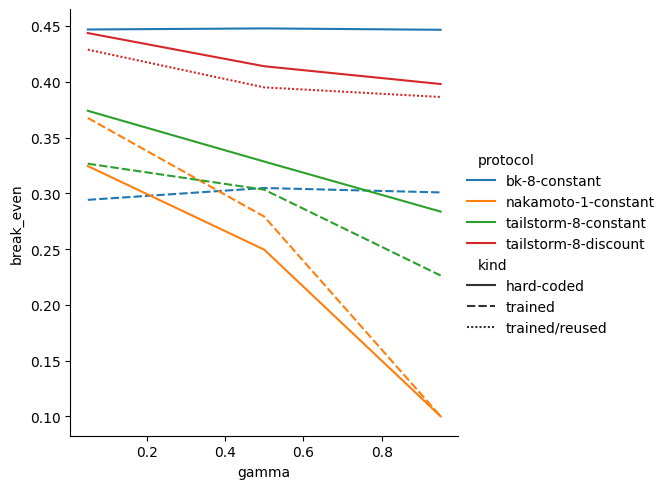

In [20]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    kind="line",
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

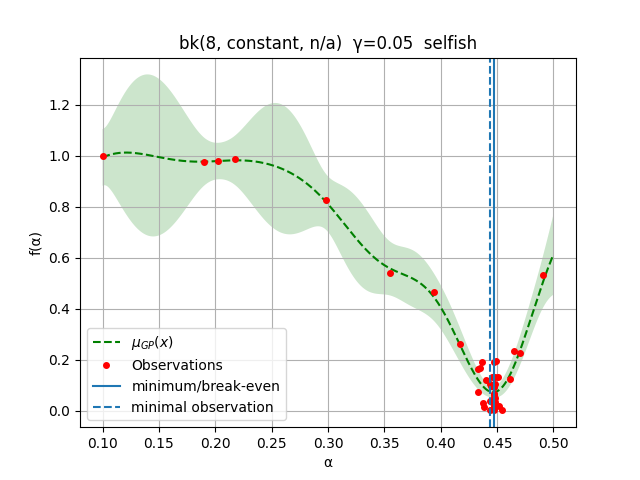

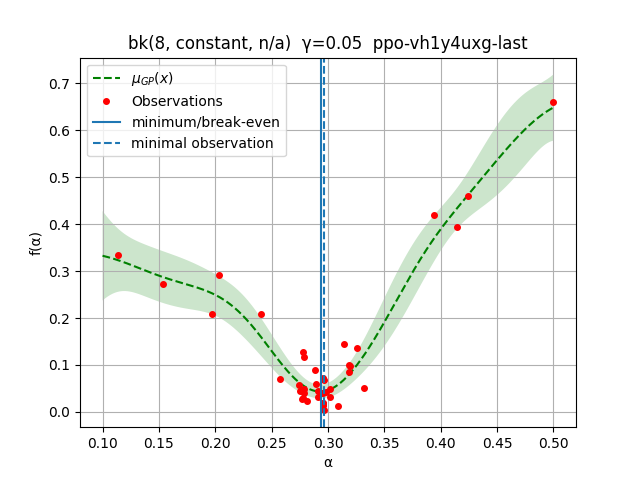

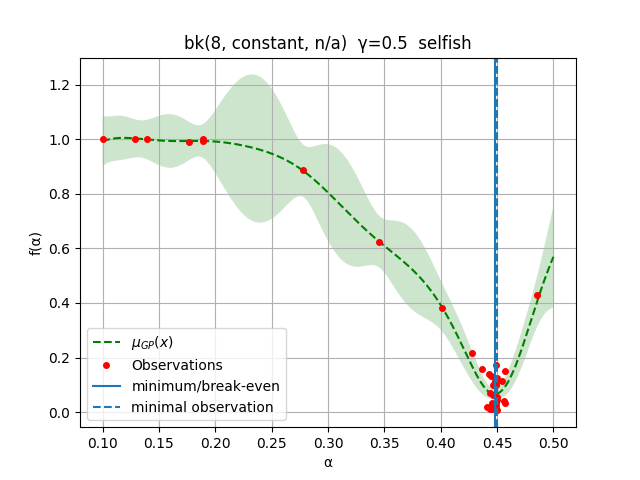

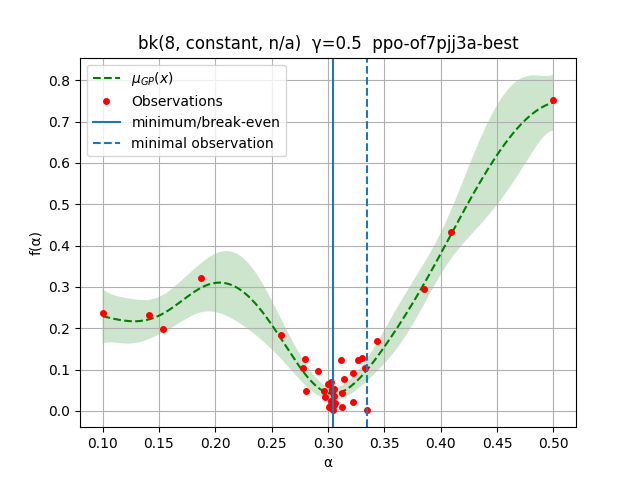

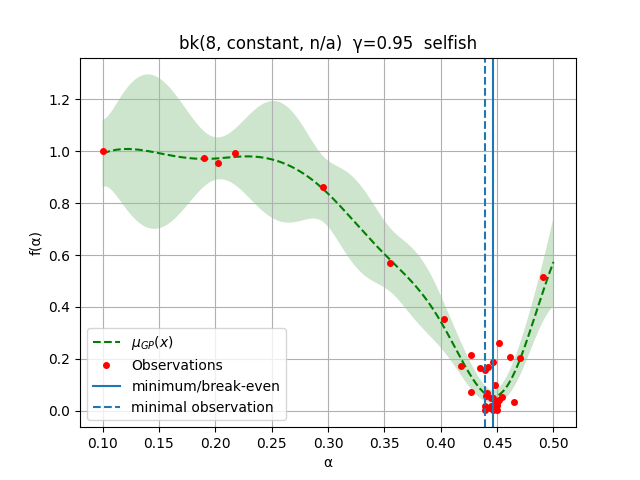

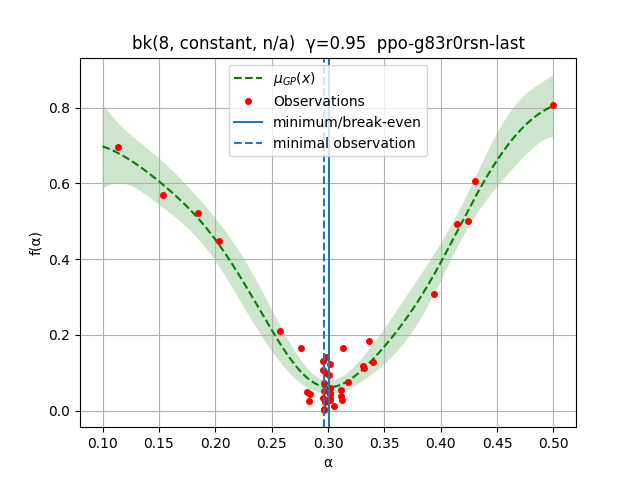

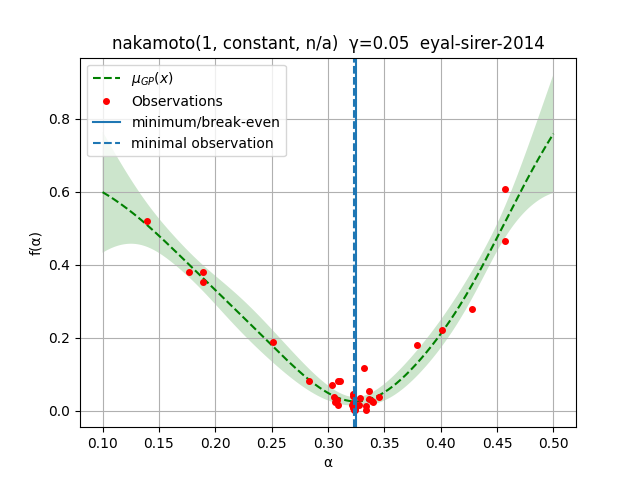

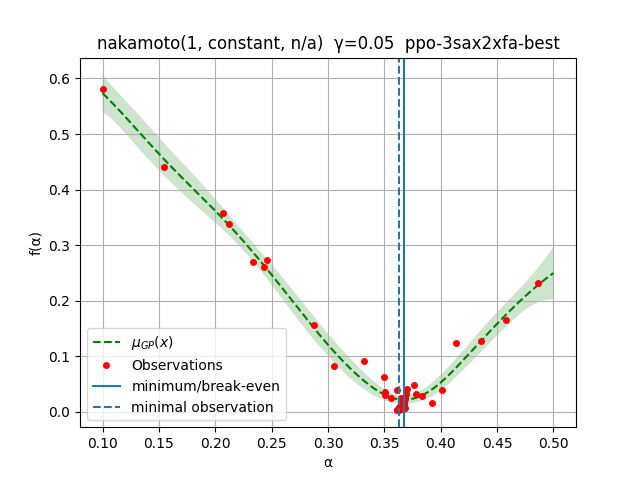

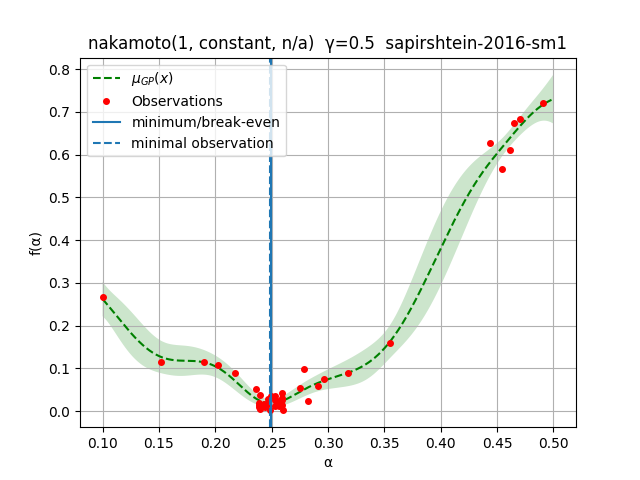

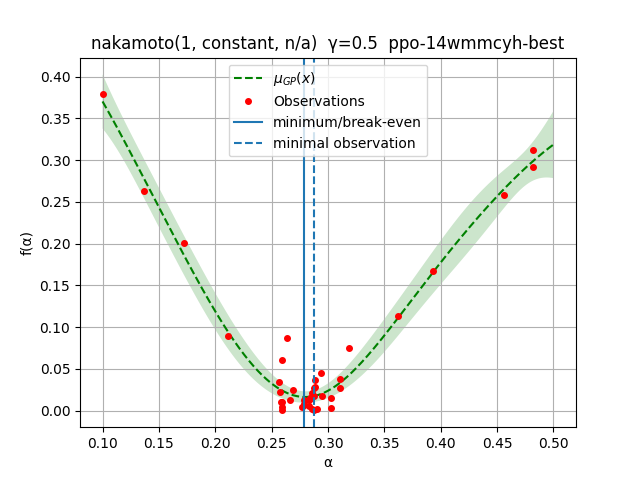

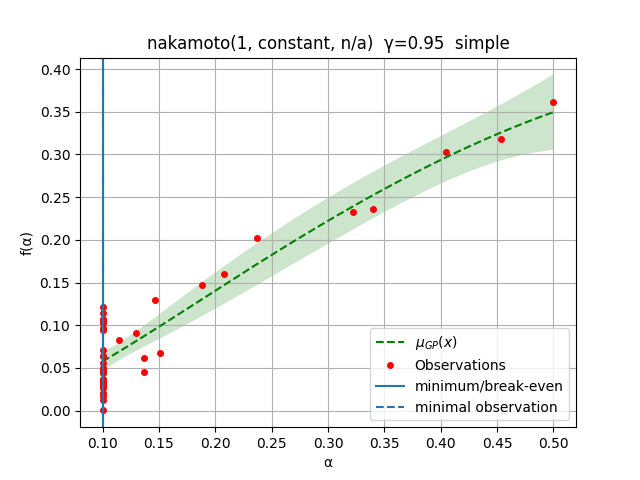

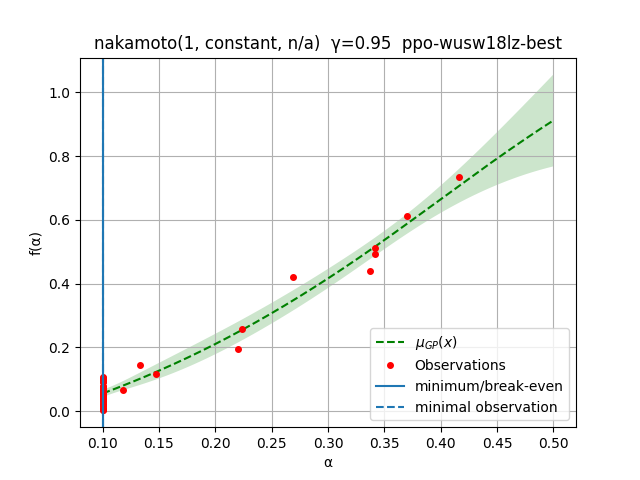

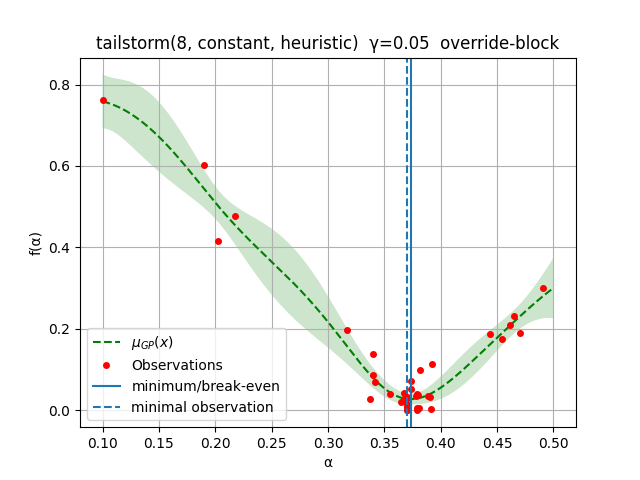

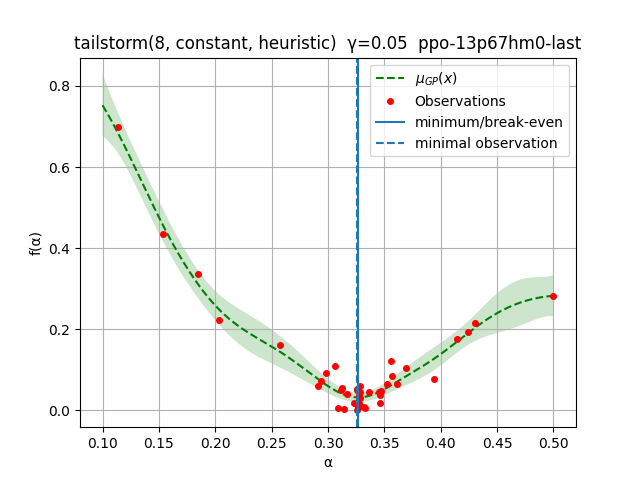

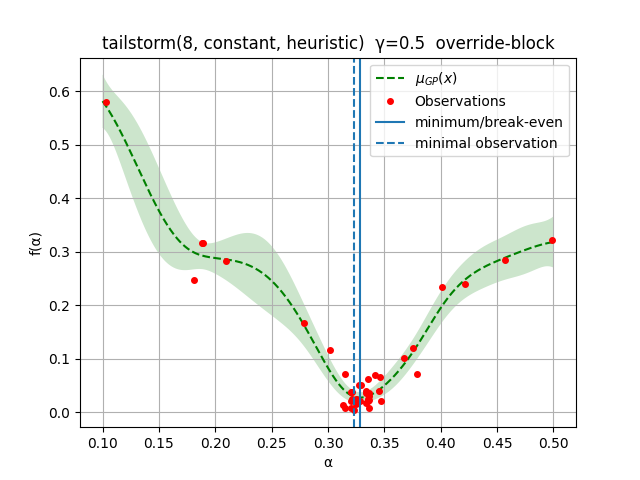

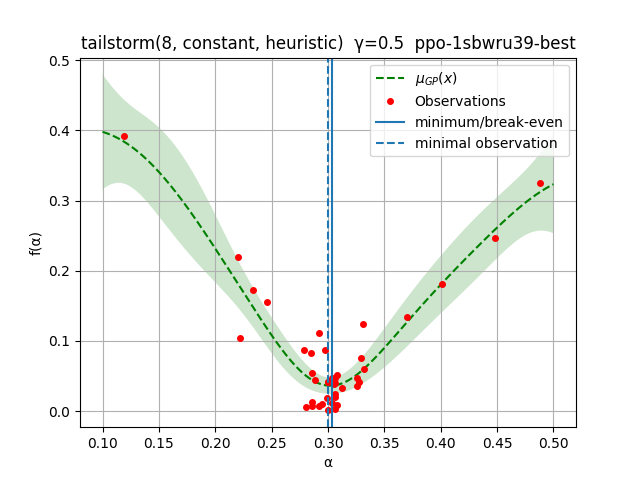

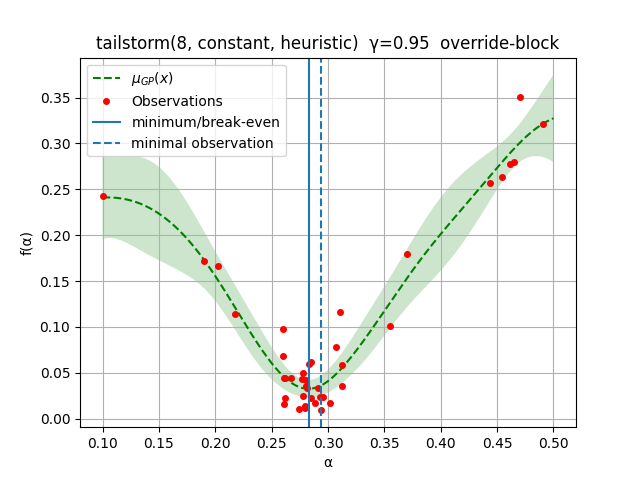

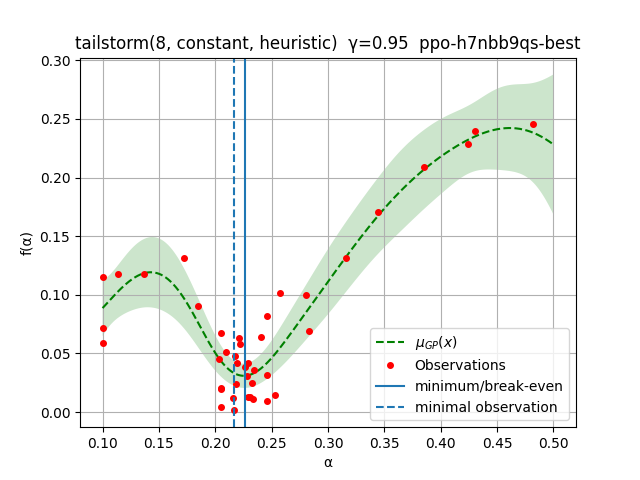

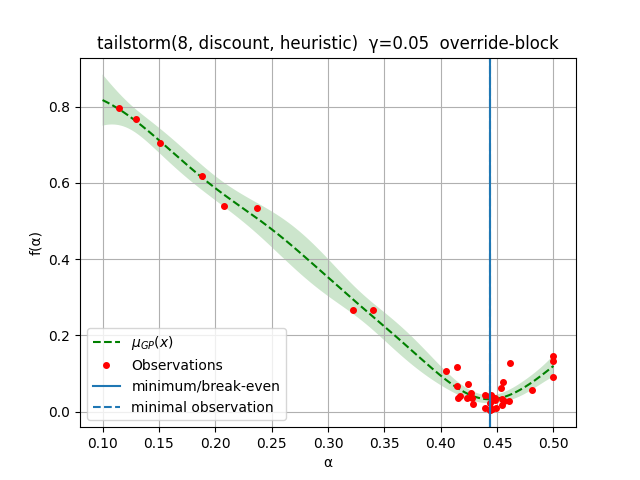

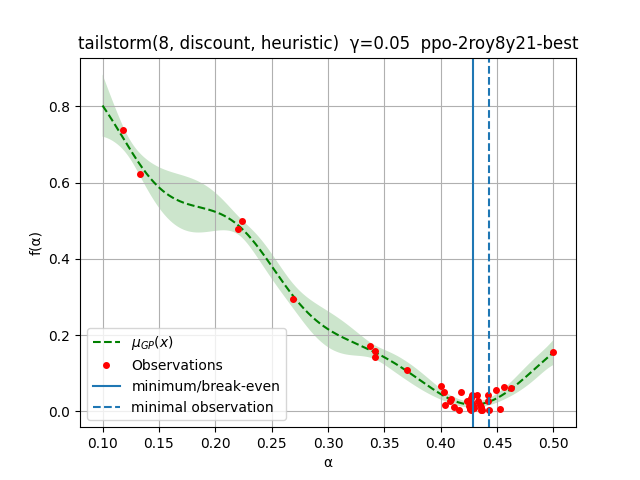

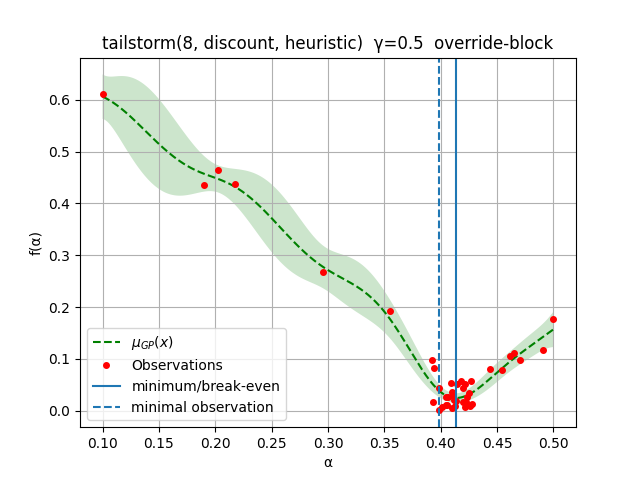

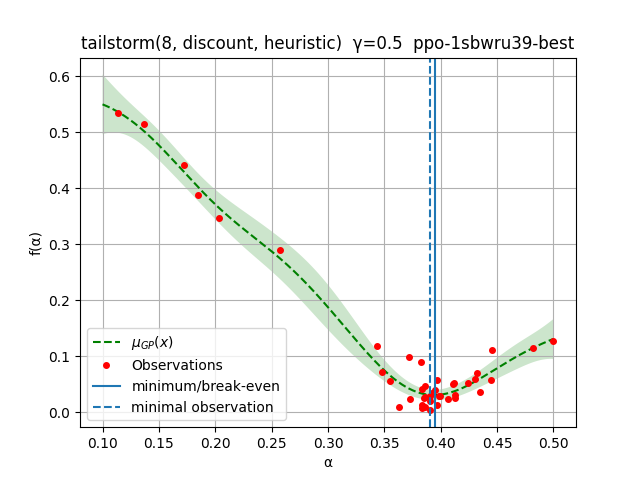

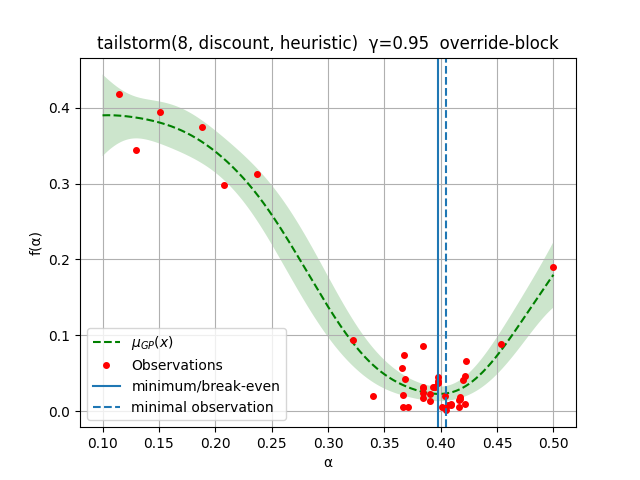

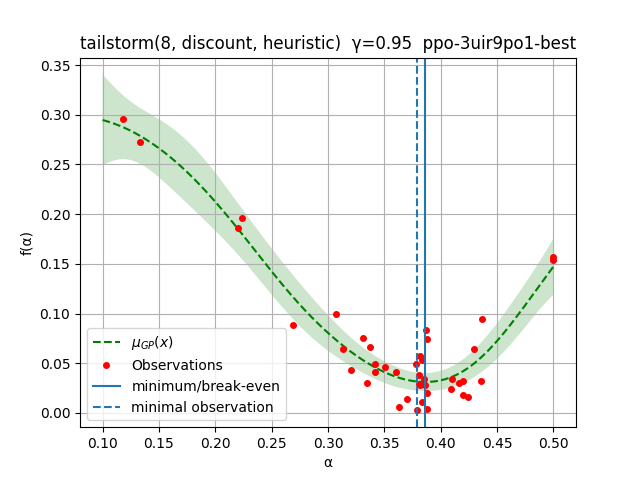

In [21]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)